In [4]:
!pip install keras-tuner


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import os
import tqdm
import pandas as pd
import keras
import time, warnings
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import KFold, train_test_split, LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [7]:

#class for plotting
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder):
    metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/processed_data.csv')
    folds = {}
    for fold in range(1, 11):
        fold_path = os.path.join(root_folder, f"fold{fold}")
        image_data = []
        all_labels = []
        if not os.path.exists(fold_path):
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(fold_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(fold_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (76, 33):
                      continue
                    image_array = normalize(image_array)
                    #image_array = tensorflow.image.grayscale_to_rgb(image_array)
                    #print(image_array.shape)
                    image_array = np.ndarray(shape=(image_array.shape[0], image_array.shape[1], 1), dtype= np.uint8)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    #print(f'Double check: image {new_filename} has label {label}')
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        #print(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels - 1, num_classes=10)
        #converting numpy arrays to tf.tensor for GPU optimization
        image_data_tensor = tensorflow.convert_to_tensor(image_data)
        all_labels_tensor = tensorflow.convert_to_tensor(all_labels)
        #print(image_data_tensor)
        image_data_tensor = tensorflow.image.grayscale_to_rgb(image_data_tensor)
        folds[f"fold{fold}"] = [image_data_tensor, all_labels_tensor]
    return folds


root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/both"
data = conv_array(root_folder)
input_shape = data['fold1'][0].shape
#input_shape = input_shape + (3,)
print(input_shape)

100%|██████████| 837/837 [00:03<00:00, 237.22it/s]

(873, 76, 33, 3)


In [8]:

print(input_shape)
input_shape2 = input_shape[1:4]
print(input_shape2)

(873, 76, 33, 3)
(76, 33, 3)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 76, 33, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 82, 39, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 38, 17, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 38, 17, 64)           256       ['conv1/conv[0][0]']      

  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.34808, saving model to model.h5
61/61 - 126s - loss: 2.1627 - accuracy: 0.3317 - val_loss: 3.3481 - val_accuracy: 0.2646 - lr: 0.0100 - 126s/epoch - 2s/step
Epoch 2/30

Epoch 2: val_loss improved from 3.34808 to 1.76515, saving model to model.h5
61/61 - 82s - loss: 1.6448 - accuracy: 0.4279 - val_loss: 1.7651 - val_accuracy: 0.3780 - lr: 0.0100 - 82s/epoch - 1s/step
Epoch 3/30

Epoch 3: val_loss improved from 1.76515 to 1.54198, saving model to model.h5
61/61 - 78s - loss: 1.5278 - accuracy: 0.4682 - val_loss: 1.5420 - val_accuracy: 0.4296 - lr: 0.0100 - 78s/epoch - 1s/step
Epoch 4/30

Epoch 4: val_loss improved from 1.54198 to 1.40703, saving model to model.h5
61/61 - 75s - loss: 1.4543 - accuracy: 0.4839 - val_loss: 1.4070 - val_accuracy: 0.4456 - lr: 0.0100 - 75s/epoch - 1s/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.40703
61/61 - 73s - loss: 1.3685 - accuracy: 0.5076 - val_loss: 1.

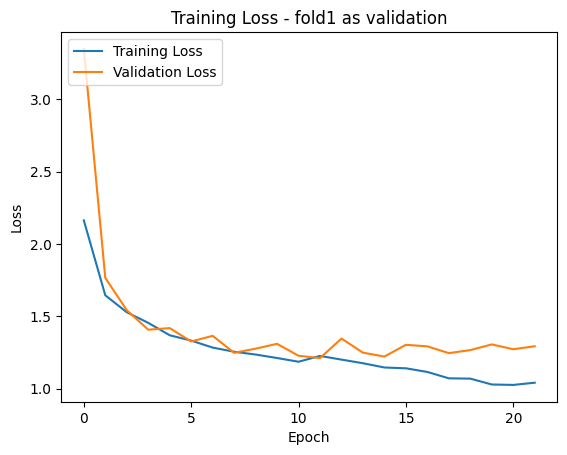

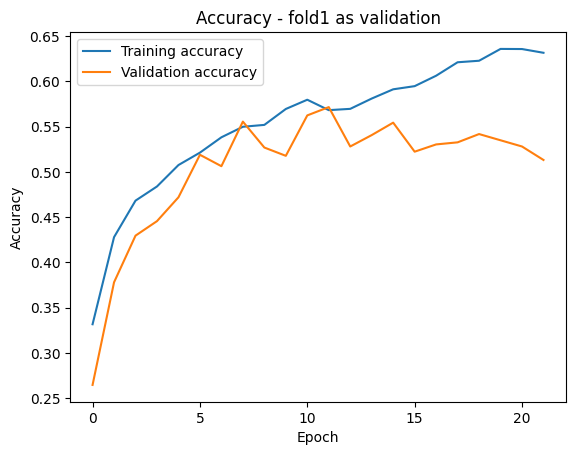

 10%|█         | 1/10 [30:56<4:38:26, 1856.25s/it]

Training using fold2 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 1.06328, saving model to model.h5
61/61 - 87s - loss: 1.0322 - accuracy: 0.6379 - val_loss: 1.0633 - val_accuracy: 0.6137 - lr: 0.0025 - 87s/epoch - 1s/step
Epoch 2/30

Epoch 2: val_loss did not improve from 1.06328
61/61 - 73s - loss: 1.0160 - accuracy: 0.6384 - val_loss: 1.1368 - val_accuracy: 0.5878 - lr: 0.0025 - 73s/epoch - 1s/step
Epoch 3/30

Epoch 3: val_loss did not improve from 1.06328
61/61 - 70s - loss: 1.0019 - accuracy: 0.6450 - val_loss: 1.0945 - val_accuracy: 0.5923 - lr: 0.0025 - 70s/epoch - 1s/step
Epoch 4/30

Epoch 4: val_loss did not improve from 1.06328
61/61 - 70s - loss: 0.9852 - accuracy: 0.6489 - val_loss: 1.1195 - val_accuracy: 0.5800 - lr: 0.0025 - 70s/epoch - 1s/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.06328
61/61 - 75s - loss: 0.9755 - accuracy: 0.6528 - val_loss: 1.0886 - val_accuracy: 0.6014 - lr: 0.0025 - 75s/epoch - 1s/step
Epoch 6/30

Epoch 6: ReduceLR

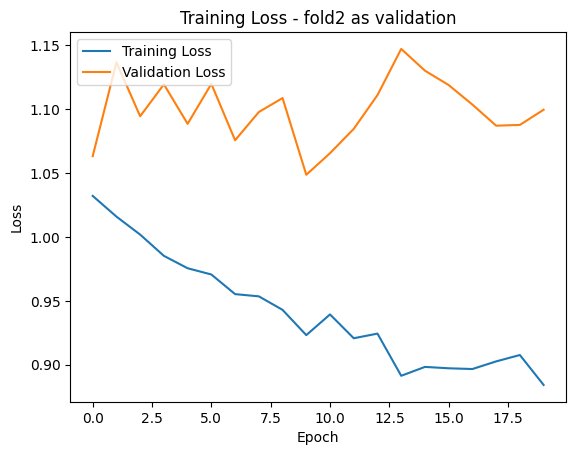

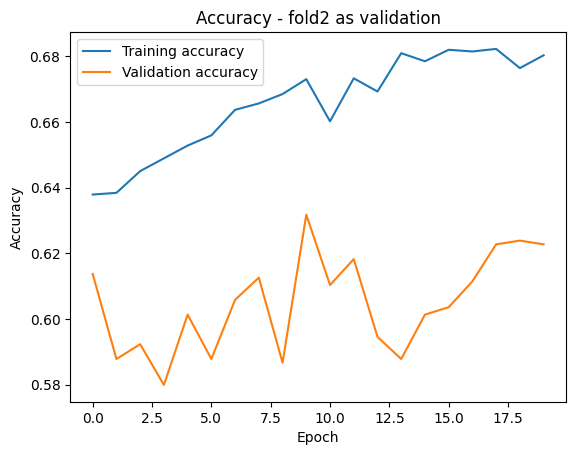

 20%|██        | 2/10 [57:06<3:45:05, 1688.19s/it]

Training using fold3 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.96108, saving model to model.h5
60/60 - 88s - loss: 0.9248 - accuracy: 0.6743 - val_loss: 0.9611 - val_accuracy: 0.6822 - lr: 0.0010 - 88s/epoch - 1s/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.96108
60/60 - 74s - loss: 0.9012 - accuracy: 0.6761 - val_loss: 0.9678 - val_accuracy: 0.6822 - lr: 0.0010 - 74s/epoch - 1s/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.96108
60/60 - 75s - loss: 0.8941 - accuracy: 0.6819 - val_loss: 0.9879 - val_accuracy: 0.6681 - lr: 0.0010 - 75s/epoch - 1s/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.96108
60/60 - 70s - loss: 0.8862 - accuracy: 0.6837 - val_loss: 0.9841 - val_accuracy: 0.6649 - lr: 0.0010 - 70s/epoch - 1s/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.96108
60/60 - 75s - loss: 0.8825 - accuracy: 0.6868 - val_loss: 1.0126 - val_accuracy: 0.6659 - lr: 0.0010 - 75s/epoch - 1s/step
Epoch 6/30

Epoch 6: val_loss

In [ ]:
tensorflow.keras.backend.clear_session()

metric = 'accuracy' #evaluation metric
#metric = tensorflow.keras.metrics.MeanAveragePrecisionMetric(topn=2)
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 30
batch_size = 256
early_stop = 10 # early stoppping after 3 epochs with no improvement of test data


def model_k_cross(data):
    list_scores = []
    #Densenet121 model using pretrained weights from imagenet
    model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=input_shape[1:4], classes=10)

    x=model_d.output
    x= GlobalAveragePooling2D()(x)
    x= BatchNormalization()(x)
    x= Dropout(0.5)(x)
    x= Dense(1024,activation='relu')(x)
    x= Dense(512,activation='relu')(x)
    x= BatchNormalization()(x)
    x= Dropout(0.5)(x)
    preds=Dense(10,activation='softmax')(x) #FC-layer
    model=Model(inputs=model_d.input,outputs=preds)

    #instance of Adam optimizer
    Adam = keras.optimizers.Adam(learning_rate=0.010)


    #To avoid the problem of overfitting, avoid training the entire network. layer.trainable=False will freeze all the layers, keeping only the last eight layers (FC) to detect edges and blobs in the image. Once the model is fitted well, it can be fine-tuned by using layer.trainable=True.
    for layer in model.layers[:-12]:
        layer.trainable=False
    for layer in model.layers[-12:]:
        layer.trainable=True

    model.summary()



    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()
        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)


        #If the model sees no change in validation loss the ReduceLROnPlateau function will reduce the learning rate, which often benefits the model. The ImageDataGenerator function performs real-time data augmentation over generated tensor image data batches in a loop.
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
        datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)
        datagen.fit(X_train)

        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                       steps_per_epoch=X_train.shape[0] //128,
                       epochs=num_epoch,
                       verbose=2,
                       callbacks=[anne, checkpoint, EarlyStoppingCallback],
                       validation_data=(X_val, y_val))

        # Evaluation
        scores = model.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])


        # Plot training history - loss
        print(history.history.keys())
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()


    average_acc = sum(list_scores) / len(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc}')

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    label = ['air_conditioning', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

    Ypred = model.predict(X_val)
    Ypred = np.argmax(Ypred, axis=1)
    Ytrue = np.argmax(y_val, axis=1)
    cm = confusion_matrix(Ytrue, Ypred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)

    for i in range(len(Ypred)):
        if np.argmax(Ypred[i]) == np.argmax(y_val[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1

    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')


model_k_cross(data)

